# Neural network implementation of the rough Heston model
Here we illustrate how to use the neural network implementation of the rough Heston model.

Remarks: 

o Although still fast, the code has not been optimised for speed (the Matlab version has).

o The underlying models are not implemented in Python. You must therefore consult the Matlab code to check the accuracy against the actual pricing models.

The source code for the module 'NeuralNetworkPricing' can be found in "...\\code\\python_code"

## Import libraries and set directories

In [1]:
import sys, os
import numpy as np

project_folder = os.path.dirname(os.path.dirname(os.path.abspath('')))
source_code = project_folder + "\\code\\python_code"
weights_folder = project_folder + "\\code\\neural_networks\\data\\neural_network_weights\\rheston"
contracts_folder = project_folder + "\\code\\neural_networks\\data"

sys.path.append(source_code)
import NeuralNetworkPricing as nnp

## Pricing with the neural networks

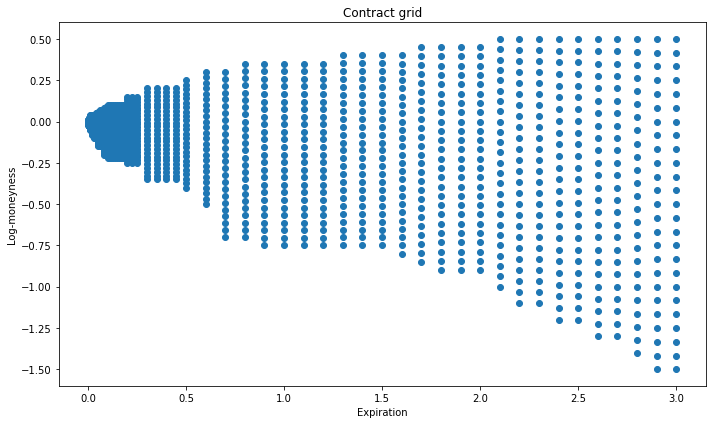

In [2]:
# Define neural network based (rough heston) model:
model = nnp.NeuralNetworkPricer(contracts_folder,weights_folder,"rheston")

# Plot the neural network contract grid:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
plt.scatter(model.T,model.k)
plt.title("Contract grid")
plt.xlabel("Expiration")
plt.ylabel("Log-moneyness")
plt.tight_layout()
plt.show()

In [19]:
# Set parameters:
H = 0.1
nu = 0.3
rho = -0.65
xi = pow(0.10,2)*np.ones((28,1))
par = np.append(np.array([H,nu,rho]),xi).reshape(31,1)

# Remark: Parameter order is (H,nu,rho,xi0,xi1,xi2,...,xi27) where v0 = xi0 and
# the maturities for the forward variances are those below:
print(model.Txi)

# Check non-negativity requirement:
t = model.Txi[1:].reshape(27,1)
theta = nnp.GetThetaFromXi(xi[0],H,t,xi[1:])
print(nnp.CheckNonNeqReqTheta(xi[0],H,t,theta)[0])

[0.00e+00 2.50e-03 5.00e-03 7.50e-03 1.00e-02 1.25e-02 1.50e-02 1.75e-02
 2.00e-02 4.00e-02 6.00e-02 8.00e-02 1.00e-01 1.20e-01 1.40e-01 1.60e-01
 2.80e-01 4.00e-01 5.20e-01 6.40e-01 7.60e-01 8.80e-01 1.00e+00 1.25e+00
 1.50e+00 1.75e+00 2.00e+00 3.00e+00]
True


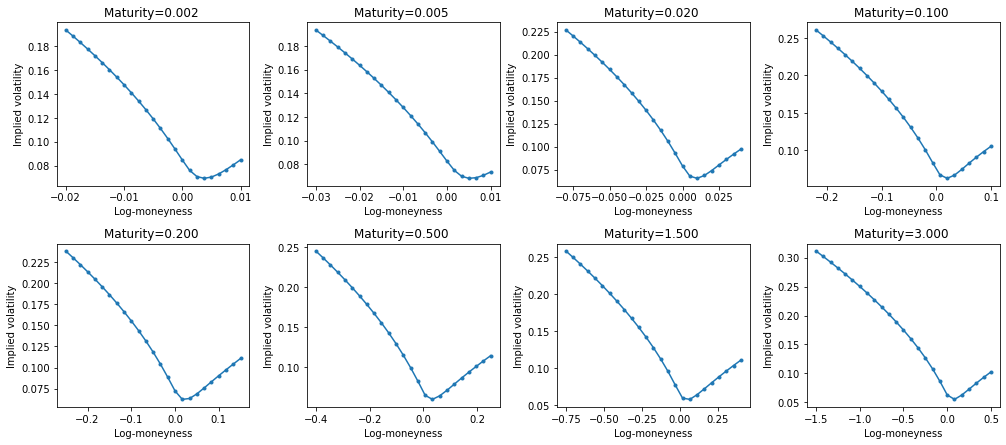

In [20]:
# Evaluate model in the contract grid:
iv_grid = model.Eval(par,model.k,model.T)

# Plot a few expiries:
npts = 25
plt.figure(1,figsize=(14,12))
j = -1
iList = [0,3,10,21,31,38,48,63]
for i in iList:
    j = j + 1
    plt.subplot(4,4,j+1)
    plt.plot(model.k[i*npts:(i+1)*npts],iv_grid[i*npts:(i+1)*npts],'.-')
    plt.title("Maturity=%1.3f "%model.T[i*npts])
    plt.xlabel("Log-moneyness")
    plt.ylabel("Implied volatility")
    
plt.tight_layout()
plt.show()

## A calibration example

Original number of observations:  1786
After filtering: 1454


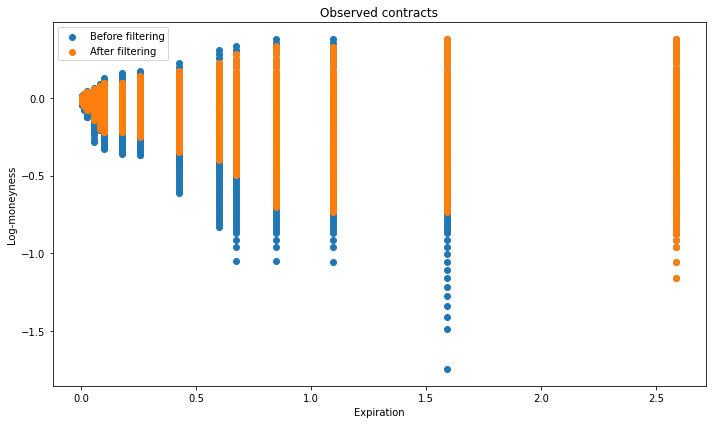

In [21]:
# Load example contracts:
tmp = np.loadtxt(project_folder + "\\get_started\\example_contracts.txt")
k_orig = tmp[:,0].reshape(-1,1)
T_orig = tmp[:,1].reshape(-1,1)

# Filter contracts that are not within the neural network domain:
idxKeep = model.AreContractsInDomain(k_orig,T_orig)
k_obs = k_orig[idxKeep,:]
T_obs = T_orig[idxKeep,:]

print("Original number of observations: ",len(k_orig))
print("After filtering:",len(k_obs))

# Plot contracts before and after filtering:
plt.figure(figsize=(10, 6))
plt.scatter(T_orig,k_orig,label="Before filtering")
plt.scatter(T_obs,k_obs,label="After filtering")
plt.title("Observed contracts")
plt.xlabel("Expiration")
plt.ylabel("Log-moneyness")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Generate synthetic prices:
parTrue = np.append(np.array([0.1,0.3,-0.65]),(pow(0.15,2))*np.ones((1,28))).reshape(31,1)
iv_obs = model.Eval(parTrue,k_obs,T_obs)

# Calibrate the model to see if we can recover the parameters:
# Remark: We simplify by forcing the forward variance curve flat. This also avoids an overparameterised model.
from scipy.optimize import minimize

# Set parameter bounds:
# Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
bounds = []
eps = pow(10,-6) 
for i in range(0,len(model.lb)):
    bounds.append([model.lb[i]+eps,model.ub[i]-eps])
    
# Fix the forward variance curve flat:
bounds = bounds[0:4]
idxConvPar = np.concatenate((np.array([0,1,2]),3*np.ones(28))).astype(int)
par0 = np.array([0.2,0.6,-0.8,pow(0.25,2)])

# Define the error function:
def err_fun(parEval):
    return(np.sum(pow(iv_obs - model.Eval(parEval[idxConvPar].reshape(-1,1),k_obs,T_obs),2)))

# Optimize:
res = minimize(err_fun,par0,method='L-BFGS-B',bounds=bounds)
print("Optimisation message: ", res.message)
parCalib = res.x[idxConvPar].reshape(-1,1)

# Compare calibrated and true parameters:
print("[True , Calibrated]: ")
print(np.concatenate((parTrue,parCalib),1))

# Check non-negativity requirement:
# - Ideally, this should be included in the optimisation problem
theta = nnp.GetThetaFromXi(parCalib[3],parCalib[0],t,parCalib[4:])
print(nnp.CheckNonNeqReqTheta(parCalib[3],parCalib[0],t,theta)[0])

Optimisation message:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[True , Calibrated]: 
[[ 0.1         0.09999992]
 [ 0.3         0.29999993]
 [-0.65       -0.65000009]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]
 [ 0.0225      0.02249999]]
True


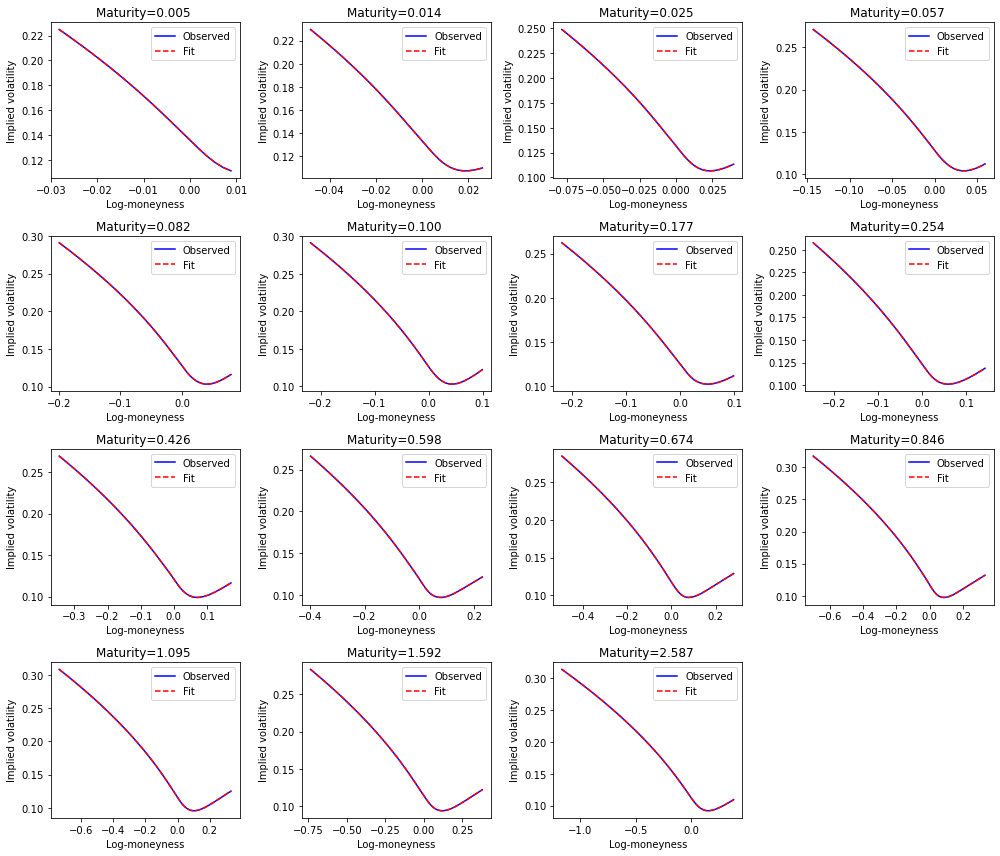

In [23]:
# Plot the fit:
iv_fit = model.Eval(parCalib,k_obs,T_obs)

uniqT = np.unique(T_obs)
npts = 25
plt.figure(1,figsize=(14,12))
j = -1
iList = np.arange(0,len(uniqT))
for i in iList:
    j = j + 1
    plt.subplot(4,4,j+1)
    idxT = T_obs == uniqT[i]
    plt.plot(k_obs[idxT],iv_obs[idxT],'b',label='Observed')
    plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
    plt.title("Maturity=%1.3f "%uniqT[i])
    plt.xlabel("Log-moneyness")
    plt.ylabel("Implied volatility")
    plt.legend()
plt.tight_layout()
plt.show()